# 2nd Meeting programme
+ Date: Friday, 25 Jan 2019
+ Time: 3.00pm to 5.00pm
+ Venue: Project Room 5-9, LKSLIB

## Assignment Review

### Fix postion method: 1000 shares each trade

#### By Garima

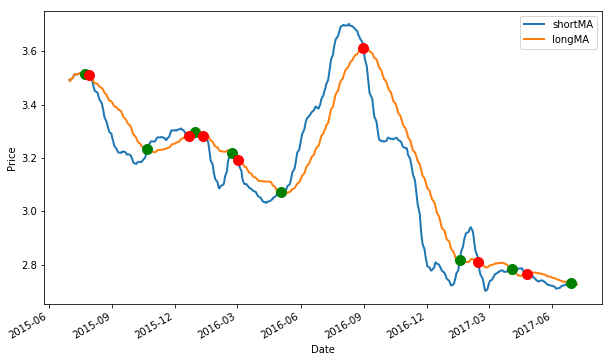

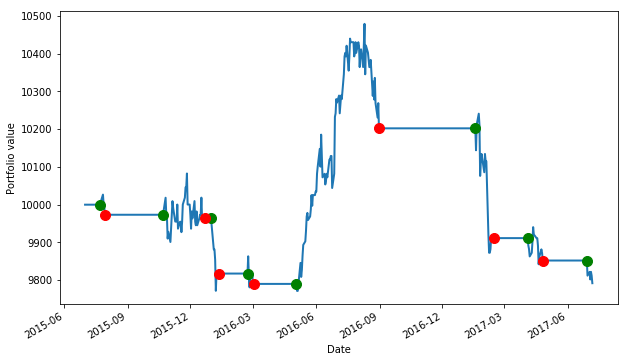

Date
2017-07-07    9792.211
Name: total, dtype: float64
Date
2017-07-07   -2.07789
Name: total, dtype: float64


In [8]:
# Moving Average Crossover 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"]=[12,8] # (optional)
data=pd.read_csv('CC3.SI.csv',index_col=0,parse_dates=True)
data.head()

short_window = 15
long_window = 50

trade_signals = pd.DataFrame(index=data.index)

trade_signals['signal'] = 0.0

trade_signals['shortMA'] = data['Adj Close'].rolling(window=short_window, min_periods = 1, center=False).mean()
trade_signals['longMA'] = data['Adj Close'].rolling(window=long_window, min_periods = 1, center=False).mean()

trade_signals['signal'][short_window:] = np.where(trade_signals['shortMA'][short_window:] > trade_signals['longMA'][short_window:], 1.0, 0.0)

trade_signals['position'] = trade_signals['signal'].diff()
trade_signals.head()

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(111, ylabel = 'Price')
trade_signals[['shortMA', 'longMA']].plot(ax=ax1, lw=2.)
ax1.plot(trade_signals.loc[trade_signals.position == 1.0].index, trade_signals.shortMA[trade_signals.position == 1.0], 'o', markersize = 10, color = 'green')
ax1.plot(trade_signals.loc[trade_signals.position == -1.0].index, trade_signals.shortMA[trade_signals.position == -1.0], 'o', markersize = 10, color = 'red')

plt.show()


capital = float(10000)
shares = 1000

df = pd.DataFrame(index = data.index).fillna(0.0)

df['Position'] = shares*trade_signals['signal']

backtest = df.multiply(data['Adj Close'], axis=0)

diff = df.diff()

backtest['shares'] = (df.multiply(data['Adj Close'], axis=0)).sum(axis=1)

backtest['cash'] = capital - (diff.multiply(data['Adj Close'], axis=0)).sum(axis=1).cumsum()

backtest['total'] = backtest['cash'] + backtest['shares']

backtest['returns'] = backtest['total'].pct_change()

#del backtest['Position']

backtest


fig = plt.figure(figsize = (10,6))

ax2 = fig.add_subplot(111, ylabel = 'Portfolio value')

backtest['total'].plot(ax = ax2, lw = 2.)

ax2.plot(backtest.loc[trade_signals.position == 1.0].index, 
         backtest.total[trade_signals.position == 1.0], 
         'o', markersize = 10, color = 'green')

ax2.plot(backtest.loc[trade_signals.position == -1.0].index, 
         backtest.total[trade_signals.position == -1.0], 
         'o', markersize = 10, color = 'red')

plt.show()

final_value = backtest['total'].tail(1)
print(final_value)

total_return = ((final_value/capital) - 1.0)*100
print(total_return)

#### By Penghui
1. when 15d >= 50 d, I have a buying signal, my position is 1000 (all position)
2. when 15d <= 50 d, my postion is 0 (no position)
3. my daily yield come from the daily change
    1. when the position is 1000, $pnl_t=change_t\times 1000$
    2. when position is 0, $pnl_t=0$
4. cum_pnl=$\sum_{t=1}^{t=T}(pnl_t)$

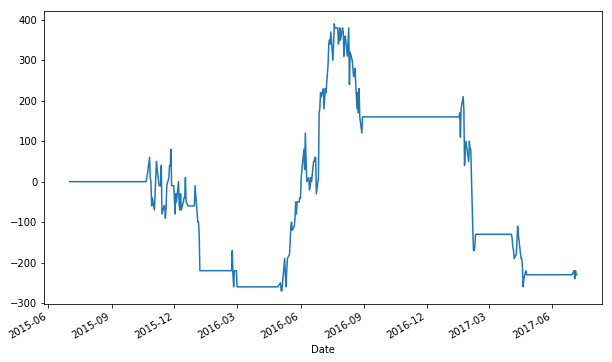

In [10]:
# Moving Average Crossover 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"]=[12,8] # (optional)
data=pd.read_csv('CC3.SI.csv',index_col=0,parse_dates=True)
data.drop(data.index[data['Volume']==0],inplace=True)
data['15d']= np.round(data['Adj Close'].rolling(window=15).mean(),3)
data['50d']= np.round(data['Adj Close'].rolling(window=50).mean(),3)

data['change']=data['Close']-data['Close'].shift(1)  
data.loc[data['15d']>data['50d'],'pos']=1000
data['pos'].fillna(0, inplace=True)
data['pnl']=data.pos*data.change
data['cumpnl']=data['pnl'].cumsum()
data[['Close', 'change','pos','pnl','cumpnl']].tail(20)

fig, ax = plt.subplots(figsize = (10,6))
data.cumpnl.plot()
plt.show()

### fixed inital value method
#### by Shen Li


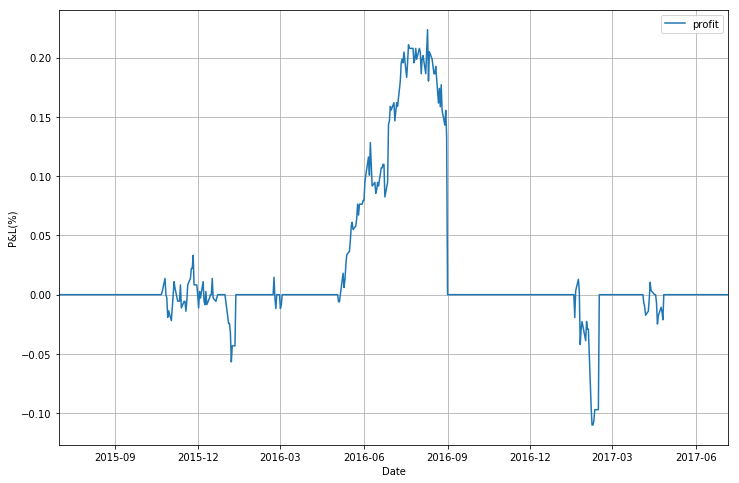

Gross Profit is:  -3.9507 %


In [12]:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

data = pd.read_csv('CC3.SI.csv', index_col = 0, parse_dates = True)
data.drop(['Open','Close','High','Low','Volume'], axis=1, inplace = True)

#compute 15days and 50days average
data['M15'] = data['Adj Close'].rolling(15).mean()
data['M50'] = data['Adj Close'].rolling(50).mean()

#difference between 15days and 50days
diff = data['M15'] - data['M50']

#transfer positive num to 1, negative num to 0
diff[diff <= 0] = 0
diff[diff > 0] = 1

#
diff = diff.diff()
buy = diff.index[diff > 0 ]
sell = diff.index[diff < 0]

#
data['crossSell'] = np.nan
data.loc[sell,'crossSell'] = data.loc[sell,'Adj Close']
data['crossBuy'] = np.nan
data.loc[buy,'crossBuy'] = data.loc[buy,'Adj Close']

#
for i in range(6):
    data.loc[data.index[(data.index >= buy[i]) & (data.index <= sell[i])],'x0'] = data.loc[buy[i],'Adj Close']

data['x'] = data['Adj Close'] - data['x0']

data.loc[data[data['x0'] != data['x0']].index, 'x0'] = 0
data.loc[data[data['x'] != data['x']].index, 'x'] = 0

data['profit precent'] = data['x']/data['x0']
data['profit precent'].fillna(0,inplace= True)

netprofit = data.loc[sell,'profit precent'].sum()

# plot graph
plt.plot(data['profit precent'],label = 'profit')
plt.xlabel('Date')
plt.ylabel('P&L(%)')
plt.grid()
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.show()

print('Gross Profit is: ', round(netprofit*100,4),'%')

#### by Penghui
1. when 15d >= 50 d, I have a buying signal, my position is 1 (all position)
2. when 15d <= 50 d, my postion is 0 (no position)
3. my daily yield come from the daily pct
    1. when the position is 1, $yield_t=pct_t$
    3. when position is 0, $yield_t=0$
4. cum_yield=$\prod_{t=1}^{t=T}(1+pct_t)$-1

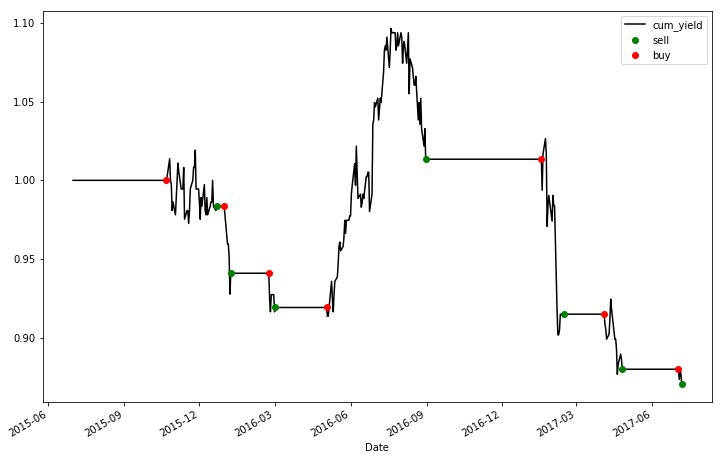

total return is -12.96%


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams["figure.figsize"]=[12,8] # (optional)
data=pd.read_csv('CC3.SI.csv',index_col=0,parse_dates=True)
data.drop(data.index[data['Volume']==0],inplace=True)
data['15d']= np.round(data['Adj Close'].rolling(window=15).mean(),3)
data['50d']= np.round(data['Adj Close'].rolling(window=50).mean(),3)

data['pct'] = data.Close.pct_change(1).fillna(0)
data.loc[data['15d'] >data['50d'], 'flag'] = 1
data['flag']=data['flag'].shift(periods=1) 
data['flag'].fillna(0, inplace=True)
data['daily_yield'] = data.pct * data['flag']
data['cum_yield'] = (1+data['daily_yield']).cumprod()
data[['Close', 'pct','flag','daily_yield','cum_yield']].tail(10)

fig, ax = plt.subplots()
x=data['15d']-data['50d']
x[x>0]=1
x[x<=0]=0
y=x.diff()
idxSell=y.index[y<0]
idxBuy=y.index[y>0]
data.loc[idxBuy,'buy']=data.loc[idxBuy,'cum_yield']
data.loc[idxSell,'sell']=data.loc[idxSell,'cum_yield']
data[['cum_yield', 'sell','buy']].plot(ax=ax, style=['k-','go','ro'])
plt.show()
print('total return is {:.2%}'.format(data['cum_yield'][-1]-1) )

##  indicators overview
sector | type | name
-|-|-
techinical analysis |  average line | EMA10 /120
| | BBI
| | Tema10
| over long and over short | Bollinger Bands
| | KDJ
| | RVI
| | DBCD
| energy| CR
| | MassIndex
| | Elder 
| Trend | ASI
| | EMV
| |MACD
| |SwingIndex
momuntumn | ARC |
| APBMA |
| CCI10 |
| REVS5m20 |
emotional | AR| 
| BR |
| Psy |
| JDQS |
profit & risk | Variance| 
| Kurtosis |
| alpha20 |
| beta20 |

## performance indicator
type | name/defination
-|-
basic | trading time, winning rate, profit
p&l ratio | total profit/ total loss
Reward-Risk ratio |  total profit/max drawdown
sharpe ratio | mean profit/ std

## transaction log
type | name/defination
-|-
daily postion| cst, cump&l
account info | total value, daily p&l, cu

# Task 2 Description
+ Data: Using data from Dr.Zhao\`s lectures, S3-5, named `CC3.SI.csv`.
+ Time interval: The same as the data\`s
+ Strategy:  MA15--MA50
    + when 15 MA exceed 50 MA, immediately buy the stock (no delay)
    + when 50 MA exceed 15 MA, immediately sell the stock (no delay)
+ Method:
    + Fix the initial portfolio value at 10000
    + There supposed to be two account: equity account & account 
    + The numer of shares must be integer （which means there are cash left after all in; need to consider)
+ Requried outcome
    + Complusory: Plot the date (on the x axis) vs cummulated total return (on the y axis). 
    + Complusory: Plot the date (on the x axis) vs drawdown (on the y axis). 
    + Complusory: Calculate performance indicator:
        + trading times: 
        + winning rate
        + p&l ratio:$\frac{\text{total profit}}{\text{total loss}}$
        + sharpe.ratio $\frac{\text{mean profit}}{\text{std}}$
    + option: Show daily the transactions log & daily postion value

